# Exporatory data analysis for intent classification

In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')
from src.utils import load_data

pd.set_option('display.max_colwidth', 120)

### Load train data

In [2]:
train_file_path = '../dataset/train.csv'
df = load_data(train_file_path)
dataset_size = len(df)

print('Dataset size: {} samples'.format(dataset_size))
print('  {} empty labels'.format(len(df[df['intent'] == ''].index)))
print('  {} NaN labels'.format(len(df[pd.isna(df['intent'])].index)))
print('  {} empty input questions'.format(len(df[df['question'] == ''].index)))
print('  {} NaN input questions'.format(len(df[pd.isna(df['question'])].index)))

Dataset size: 14514 samples
  0 empty labels
  0 NaN labels
  0 empty input questions
  0 NaN input questions


### Number of class representants

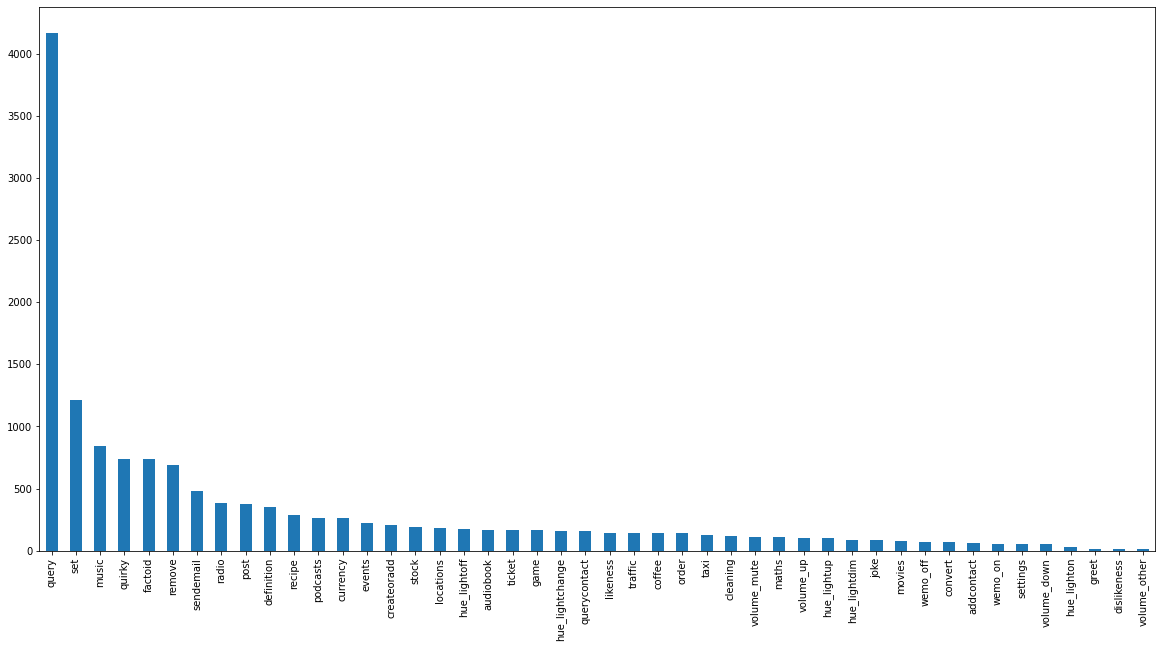

In [3]:
df['intent'].value_counts().plot(kind='bar', align='center', width=0.5, figsize=(20,10))

As shown by the plot there is a strong imbalance between the classes. This could be taken into account when implementing some sort of data augmentation (and thus oversampling the less represented classes).

### Number of characters present in each question

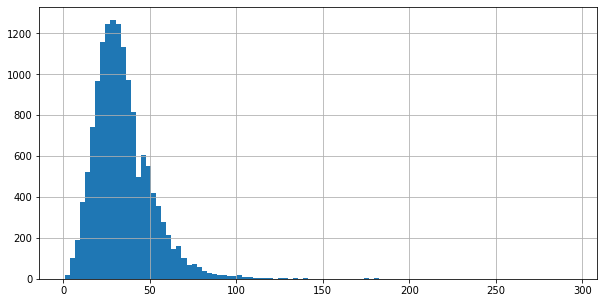

In [4]:
df['question'].str.len().hist(bins=100, figsize=(10,5))

The questions distribute quite normally around the value 30, but some questions have an higher number number of characters, and some a really small one.

In [5]:
sorted_indexes_by_nr_chars = df['question'].str.len().sort_values(ascending=False).index

By looking at the 10 longest questions it seems that they are not affected by any particular issue. Moreover they seem quite uniformely ditributed over the intent classes.

In [6]:
df.reindex(sorted_indexes_by_nr_chars).head(10)

,question,scenario,intent
5019,hack into donald trump's account and wire the funds to everyone's bank accounts by pennies before converting them to...,qa,factoid
6074,on the other hand there may be added costs involved in getting your kitchen up to pennsylvania department of agricul...,cooking,recipe
5658,"tell me what the square root of four quadrillion, five hundred and sixty four trillion, three hundred and twenty fou...",qa,maths
2171,it complements the information in drive safe a handbook for western australian road users by providing a practical g...,recommendation,events
4877,hey place an event in my calendar to go to soccer practice on friday april twenty first at one thousand one hundred ...,calendar,set
3736,start the gas stove adjust the flame to cooking the dish and put all cooking ingredient to pressure cooker to cook t...,cooking,recipe
10522,tap the system tab tap clock and then select the alarms tab tap and select the day you want the alarm to sound doubl...,alarm,query
10933,book a taxi to pick up shelley hennessey at gate four of the airport for the arrival of aa flight five thousand four...,transport,taxi
1392,hey place an event in my calendar to go to the doctor on friday april fourteenth at one hundred and twenty three wat...,calendar,set
7214,this candidate├ö├ç├ûs guide to the practical driving assessment <unk> has been prepared to help learner drivers deve...,recommendation,events


By looking at the 10 shortest questions it seems that they are not affected by any particular issue. Moreover they seem quite uniformely ditributed over the intent classes. Only the three sortest questions (being of just one character) seem meaningless. They could be removed from the dataset.

In [7]:
df.reindex(sorted_indexes_by_nr_chars).tail(10)

,question,scenario,intent
7907,hey,general,greet
7125,oll,recommendation,events
14344,cnn,news,query
14267,tv,general,quirky
404,hi,general,greet
13691,up,audio,volume_up
7379,ge,general,quirky
8264,j,calendar,set
1423,a,qa,factoid
3436,r,qa,definition


### Number of words appearing in each question
Words are split simply by spacing.

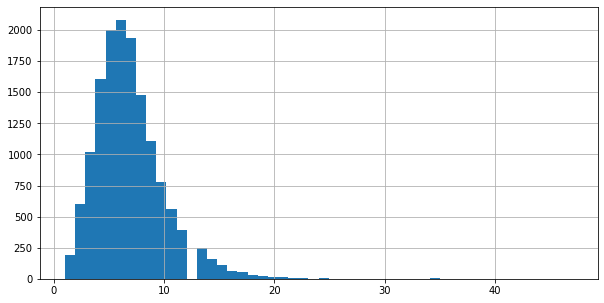

In [8]:
df['question'].str.split().map(lambda x: len(x)).hist(bins=50, figsize=(10,5))

In [9]:
sorted_indexes_by_nr_words = df['question'].str.split().map(lambda x: len(x)).sort_values(ascending=False).index

### Words length analysis
Analysis of the sortest and longest words, as well as of the average word length of each question.

In [10]:
new = df['question'].str.split().values.tolist()
corpus_original = np.array(list(set(word for i in new for word in i)))
print('Original corpus has {} words'.format(len(corpus_original)))

Original corpus has 6781 words


In [11]:
sort_index = np.argsort(list(map(len, corpus_original)))

Show the 20 shortest words in the corpus.

In [12]:
corpus_original[sort_index][:20].tolist()

['t',
 "'",
 'a',
 '@',
 'p',
 'q',
 'i',
 'o',
 'm',
 ':',
 's',
 'k',
 'c',
 'v',
 'r',
 'y',
 '[',
 '1',
 'x',
 'd']

Show the 20 longest words in the corpus.

In [13]:
corpus_original[sort_index][-20:].tolist()

['recommendations',
 'necessarychoose',
 'representatives',
 'joejoe@gmailcom',
 'newmail@gmailcom',
 'triscadecaphobia',
 'johndoe@yahoocom',
 'family├ö├ç├╢just',
 '[currency_source',
 '@realdonaldtrump',
 'candidate├ö├ç├ûs',
 "schwarzenegger's",
 'smithjoe@emailcom',
 'juanpedro@gmailcom',
 'libertarianpodcast',
 'qerwerq@dfasdfacom',
 'something@gmailcom',
 'markpolomm@gmailcom',
 'samuelwaters@hotmailcom',
 'mahaboobsayyad@gmailcom']

Show the average word length distribution over the questions.

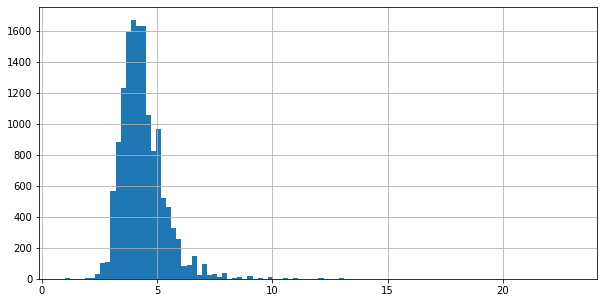

In [14]:
df['question'].str.split()\
    .apply(lambda x : [len(i) for i in x]).\
    map(lambda x: np.mean(x)).hist(bins=100, figsize=(10,5))

No particular issues are found. Two observations:

* The average word length distributes quite normally as the previous statistics (number of words and number of charaters).

* Longest words seem in general related to email addresses.

### Define stopwords for the intent classification task

### Stopwords analysis
See if some special words and some special characters can be removed. 

At first, the all the nltk default english stopwords are investigated, to see if they can be safely removed during the cleaning procedure.

In [15]:
import nltk
from collections import defaultdict
from src.utils import plot_top_stopwords_barchart, plot_word_distribution_over_intents

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/carlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


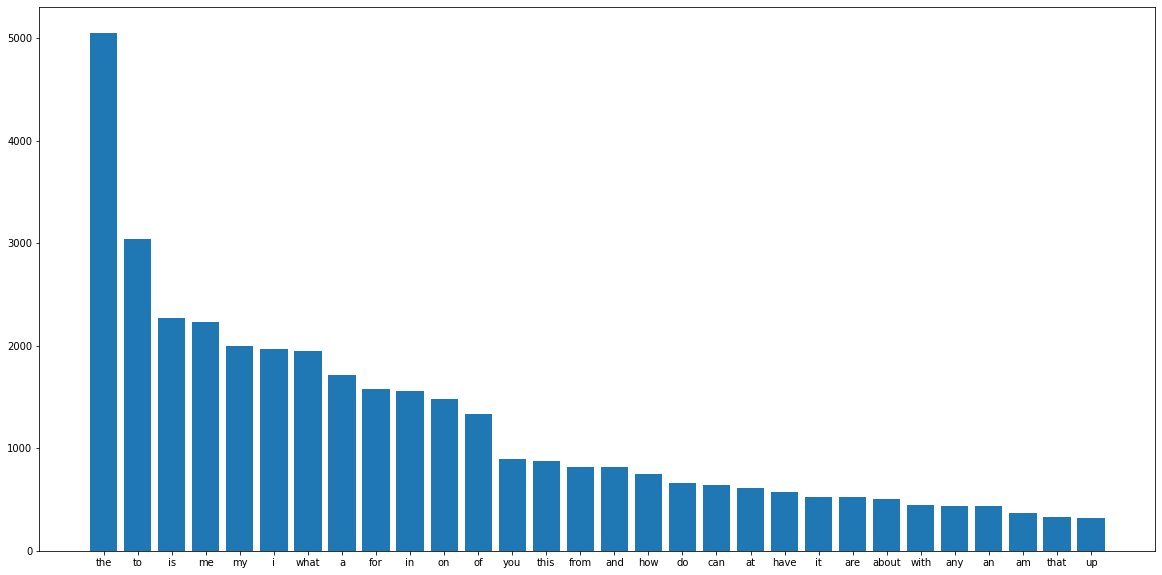

In [16]:
plot_top_stopwords_barchart(df['question'],
                            stopwords=stopwords,
                            n=30, 
                            figsize=(20,10))

Even if most of the default stopwords can be safely removed, this does not hold in general. For example the removal of some words like *what* or *who* can strongly affect negatively the relation between a question adn its intent label.

,question,intent
10,what time is set for my wake up alarm,query
12,what is the capital of new hampshire,factoid
13,what is garam masala,definition
18,what is today's day,query
22,what time does the first train depart from chicago,query
...,...,...
14492,what times are today's meetings,query
14495,what is paris time,query
14504,what is four plus four,maths
14506,what time is it in england,query


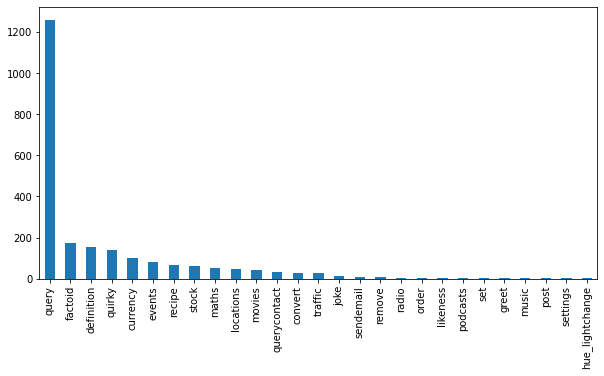

In [17]:
stopword = 'what'
plot_word_distribution_over_intents(df, stopword)
df[['question', 'intent']][df['question'].str.split().map(lambda x: stopword in x)]

This suggests to select a subset of the default stopwords set on the cleaning procedure.

### Special characters analysis
We already saw how the '@' symbol can have some information content, and thus should not be removed. 

Let's find out if there are any other special charactars that require a specific treatment.

In [20]:
import re

def is_not_clean(word):
    return re.sub(r'[^ a-z A-Z 0-9]', "", word) != word

not_clean_corpus = list(filter(is_not_clean, corpus_original))
not_clean_corpus[:10]

["george's",
 "men's",
 "'bed",
 "jay's",
 "johns's",
 "franklin's",
 "joe's",
 "julia's",
 "perry's",
 'samuelwaters@hotmailcom']

In [22]:
from functools import reduce 

special_words = set(map(lambda word: re.sub(r'[a-z A-Z 0-9]', "", word), 
                              not_clean_corpus))
special_characters = list(set(reduce(lambda x, y: x+y, special_words)))
special_characters

["'",
 '┤',
 '`',
 '>',
 'û',
 '«',
 '¡',
 '#',
 '@',
 'Γ',
 ']',
 '<',
 '┬',
 '.',
 'ö',
 'ç',
 '├',
 '£',
 '╢',
 '»',
 '$',
 ',',
 ':',
 '[',
 '_']

Show some questions containing the '#' character.

In [23]:
df[df['question'].str.contains('#')].head()

,question,scenario,intent
1950,tweet @mcdonalds your food sucks #nastyburger,social,post
4932,siri tweet to @target your store #cincinnati ohio tricounty store is messy,social,post
5057,please tweet @pizzahut i've been waiting for my delivery for now #nothappy,social,post
7963,please tweet @nike my pants ripped after the first wash #nothappy,social,post
9129,tweet @applebee my chicken was raw #foodpoisoning,social,post


Show some questions containing the '<' character.

In [24]:
df[df['question'].str.contains('<')].head()

,question,scenario,intent
109,set schedule for <unk> time date <unk> <unk> name <unk> at <unk> location <unk>,calendar,set
115,person <unk> birthday,qa,factoid
135,check new message in inbo <unk>,email,query
160,can you tell me which movie is going on in the nearby multiple <unk>,recommendation,movies
257,silence for <unk> amount of hours,audio,volume_mute


As a result we are going to keep the '@' and the '#' characters, while we will remove all the other special ones during the cleaning procedure.

Also the "< unk >" will be removed.